# Identifying the Lows of Closing Price

# Imports 

In [43]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
%matplotlib inline

import numpy as np

import yfinance as yf
import datetime as dt
from datetime import date
from sklearn import preprocessing

from sklearn.linear_model import LogisticRegression


from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.pipeline import make_pipeline

from sklearn.metrics import accuracy_score, roc_auc_score

from scipy.signal import savgol_filter, argrelmin, argrelmax 

import warnings
warnings.filterwarnings("ignore")

# Bitcoin Dataset from Yahoo Finance

In [44]:
# Here we create the present date as the end date for our yahoo finance end day.
today = date.today().strftime('%Y-%m-%d')
today

'2020-06-12'

In [45]:
# We will grab our data from Yahoo Finance
# We have to set a start date for the first initial data and th end date.
data = yf.Ticker('BTC-USD')
bit_data = data.history(start='2018-01-01',end=today)

In [46]:
bitcoin = bit_data

In [47]:
bitcoin.shape

(893, 7)

In [48]:
bitcoin.tail()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-06-07,9653.00,9768.50,9458.15,9758.85,25015250846,0,0
2020-06-08,9760.06,9782.31,9675.89,9771.49,21486346312,0,0
2020-06-09,9774.36,9836.37,9664.72,9795.70,23717842783,0,0
2020-06-10,9794.12,9908.90,9728.29,9870.09,25706567601,0,0
2020-06-12,9297.06,9540.47,9285.85,9454.11,23477944320,0,0


In [49]:
# Dropping 'Dividends' , 'Stock Splits' because they contain NO data.
bitcoin.drop(columns=['Dividends', 'Stock Splits'], inplace=True)

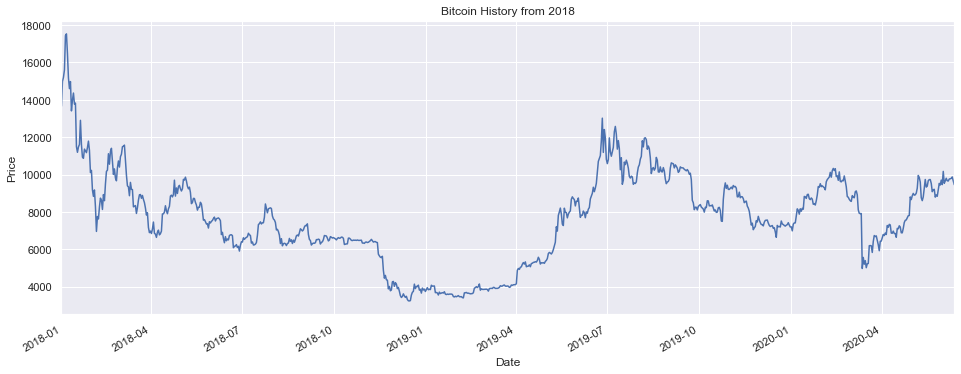

In [50]:
# Lets see our data
plt.figure(figsize=(16,6))
bitcoin.Close.plot()
plt.title('Bitcoin History from 2018')
plt.ylabel('Price');

## Smooth out the data and remove noise

### **savgol_filter**
- will smooth out our data points and make the graph less volatile.

https://docs.scipy.org/doc/scipy-0.15.1/reference/generated/scipy.signal.savgol_filter.html

In [10]:
# We create a new columns and start with with a 0 int. 
# savgol_filter will smooth out the data 
# polyorder(int) will be how smooth you want the data. (lower = more smooth)/(high = less smooth)
# Window will be the length we want to filter (must be odd int.)
window = 9
bitcoin['smooth'] = savgol_filter(bitcoin.Close, window, polyorder=6)

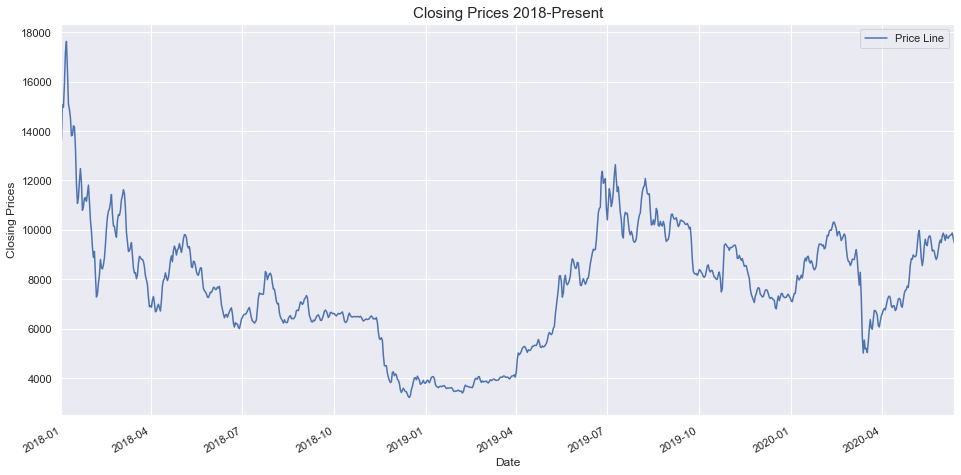

In [11]:
# less sharpness of points and visually less volatile than their original values
plt.figure(figsize=(16,8))
# bitcoin.Close.plot()
bitcoin.smooth.plot(label='Price Line')
plt.ylabel('Closing Prices')
plt.title('Closing Prices 2018-Present', fontsize=15)
plt.legend()
# plt.savefig('bitcoin_graph', transparent =True);

In [12]:
# Here we can see that the smooth column is a bit off compared to the Close column. 
# Smooth column represents Close price, but smoother or a bit less stiff
bitcoin.tail(15)

,Open,High,Low,Close,Volume,smooth
Date,,,,,,
2020-05-28,9184.95,9546.32,9148.46,9525.75,34367073114,9443.722945
2020-05-29,9528.36,9573.67,9379.34,9439.12,32896642044,9588.856636
2020-05-30,9438.91,9704.03,9366.73,9700.41,32722975141,9478.344165
2020-05-31,9700.11,9700.34,9432.30,9461.06,27773290299,9752.939984
2020-06-01,9463.61,10199.57,9450.90,10167.27,35198901068,9865.440117
2020-06-02,10162.97,10182.34,9460.57,9529.80,39137252109,9744.991857
2020-06-03,9533.76,9682.86,9471.85,9656.72,25007459262,9573.364522
2020-06-04,9655.85,9887.61,9525.25,9800.64,25921805072,9795.419479
2020-06-05,9800.22,9869.24,9663.22,9665.53,23509628646,9685.470536


### argrelmin
https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.signal.argrelmin.html
### argrelmax
https://docs.scipy.org/doc/scipy-0.16.0/reference/generated/scipy.signal.argrelmax.html#scipy.signal.argrelmax

- argrelmin/max: will find the minima/maxima 
- order is the amount of data points to the left and right. (the amount of adjacent points)

In [13]:
# we will create a new column in the dataframe and set all values to 0
# order: amount of array in which to find the relative minima
# selecting the [0], turns type numpy.ndarray(tuple does not have .tolist meth.). Turn to list type

min_ids = 'min_ids'
max_ids = 'max_ids'
bitcoin[max_ids] = 0
bitcoin[min_ids] = 0

min_id = argrelmin(bitcoin.smooth.values, order=10)[0].tolist()
max_id = argrelmax(bitcoin.smooth.values, order=10)[0].tolist()

# .iloc the min/max and turn them to 1, to indicate if they are low/high price point
# all other data will be 0 if they are not low/high indicators 
bitcoin[min_ids].iloc[min_id] = 1
bitcoin[max_ids].iloc[max_id] = 1

In [14]:
bitcoin.tail(30)

,Open,High,Low,Close,Volume,smooth,max_ids,min_ids
Date,,,,,,,,
2020-05-13,8805.39,9317.88,8805.39,9269.99,45558144023,9340.712191,0,0
2020-05-14,9271.33,9793.27,9255.04,9733.72,56426907637,9618.161966,0,0
2020-05-15,9734.29,9755.83,9261.40,9328.20,48158802327,9419.597483,0,0
2020-05-16,9333.24,9564.21,9260.69,9377.01,36164766407,9357.028834,0,0
2020-05-17,9374.93,9823.00,9349.55,9670.74,40084250662,9643.264157,0,0
2020-05-18,9675.70,9906.03,9570.36,9726.58,41827139895,9752.092960,0,0
2020-05-19,9727.06,9836.05,9539.62,9729.04,39254288954,9738.894336,0,0
2020-05-20,9725.33,9804.79,9447.20,9522.98,36546239702,9469.746169,0,0
2020-05-21,9522.74,9555.24,8869.93,9081.76,39326160532,9141.985291,0,0


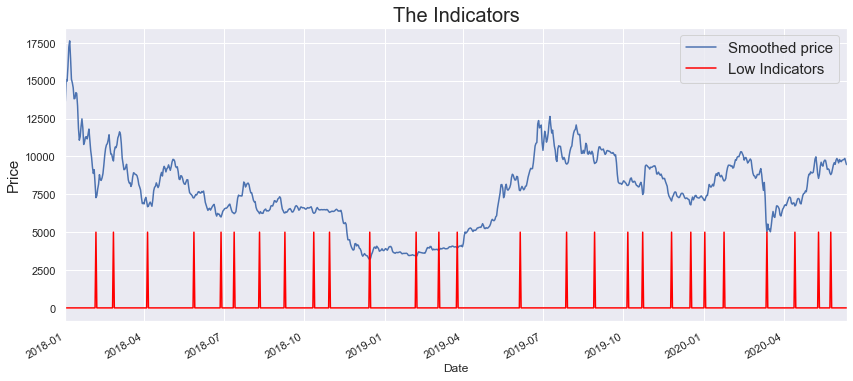

In [15]:
plt.figure(figsize=(14,6))
bitcoin.smooth.plot(label='Smoothed price')
(5000*bitcoin.min_ids).plot(color='red', label='Low Indicators')
plt.title('The Indicators', fontsize=20)
plt.ylabel('Price', fontsize=15)
plt.legend(fontsize=15);

# Baseline Model
## LogisticRegression Model: target: min_ids (Low Close Price) Best Buy Price

In [16]:
# We created a seperate list for the features dropping ['Open', 'Close', 'Low', 'High', 'min_ids']
# Keeping them may result in multicolinearity.
features_list = bitcoin.drop(columns=['Open', 'High', 'Low', 'Close', 'min_ids']).columns.tolist()

In [17]:
# These are the features we will be using
features_list

['Volume', 'smooth', 'max_ids']

In [18]:
# Lets drop all NaNs and give it a new var. 
# X(features): the clean_bit dataset with the features_list
# y(target): this is our target min_ids (the low closing values)
X = bitcoin[features_list]
y = bitcoin['min_ids']

In [19]:
# Lets scale our data so everything is on the same playing field
# We call our LogisticRegression model and give it a var. to call on it later
# We then create a pipe for the scaler and logreg
scaler = preprocessing.StandardScaler().fit(X)
LogReg = LogisticRegression(class_weight='balanced', random_state=42)
pipe = make_pipeline(scaler, LogReg)

# Here we use a roc_auc to score the ability to distinguish the difference between target
scores = cross_val_score(pipe, X, y, n_jobs=-1, cv=4, scoring='roc_auc')
scores.mean(), scores.std()

(0.7052580888986419, 0.057620446570639965)

### Initial baseline test
- our base model seems to be very unstable just looking at the std(standard deviation)
- our ROC_AUC score for the low and high prediction is very similar.

----------------------------------------------------------------------------------------------------------

# Feature Engineering

- MACD: Moving Average Convergence Divergence
    - Subtracts the 26-period Expoential Moving Average(EMA) from the 12-period (EMA). 
    - https://www.investopedia.com/terms/m/macd.asp
- Std: of rolling (n)windows
    - this will give us a standard deviation of (n)windows from the mean.
- RSI: Relative Strength Index
    - this is a momentum indicator.
    - the standard period is 14(days)
    - calulates the average gain and lose for a period of time
    - values 0 - 100
    - https://www.investopedia.com/terms/r/rsi.asp
- EWM: Exponential Weighted function
    - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.ewm.html

In [20]:
# the window we will use is a 5 and 10 day window
# we will find the avg. of these windows and subtract 
windows = [5, 10]

for w in windows:
    rm = bitcoin.Close.rolling(w).mean()
    bitcoin['MACD_'+str(w)] = rm - bitcoin.Close
    bitcoin['Std_'+str(w)] = bitcoin.Close.rolling(w).std()    
    
    
# the rsi_period will be our standard 14 day window
# Out of the 14 day period. We want to know what are the gains and losses
# 1. we will need to know the diff(1) of two diff. days periodically. 
# 2. we use mask to hide any data that is not a gain 
    # - this will hide the losses and 0 changes.
# 3. this is the same for our loss, hide anything that is not a loss

rsi_period = 14
change = bitcoin.Close.diff(1)
gain = change.mask(change<0,0)
loss = change.mask(change>0,0)

# here we use EWM to find the gain/loss with a period of time
# min_periods: will be our standard 14 day period
# com: is the period that we want to weight in
    # - we want to use the 14 day period, but compare the avg. gain/loss to the original close price
    # - hence why we subtract 1, taking the initial closing price out of the equation since we are
    # using it as a comparison
# we will do this for the gain and loss averages.
avg_gain = gain.ewm(com=rsi_period-1, min_periods=rsi_period).mean()
avg_loss = loss.ewm(com=rsi_period-1, min_periods=rsi_period).mean()

# here we find the absolute value of the relative strength for the gain and loss
rs = abs(avg_gain/avg_loss)

# this is the equation/math for RSI
# we will subtract it from 100 since the scale is 0-100.
rsi = 100 - (100/(1+rs))
bitcoin['RSI'] = rsi

# after finding and creating a new RSI column, we will drop all NANs
clean_bit = bitcoin.dropna()

In [21]:
clean_bit.shape
# we did lose a bit of information from dropping NaNs, but that's okay.

(879, 13)

### Setting up a binary classifier for RSI

In [22]:
# here we create new columns to help us identify if the RSI is >=70 or <=30
# initially we just want the columns to be all 0, we will change this later
# we call upon the new column and .loc the 'RSI' with a bool statement
# if the statement is True then we will identify it as a 1, if not then it will remain a 0

rsi_70 = 'RSI_70'
rsi_30 = 'RSI_30'
clean_bit[rsi_70] = 0
clean_bit[rsi_30] = 0
clean_bit[rsi_70].loc[bitcoin['RSI'] >=70] = 1
clean_bit[rsi_30].loc[bitcoin['RSI'] <=30] = 1

In [23]:
# we can see that our binary classifying worked
clean_bit.tail()

,Open,High,Low,Close,Volume,smooth,max_ids,min_ids,MACD_5,Std_5,MACD_10,Std_10,RSI,RSI_70,RSI_30
Date,,,,,,,,,,,,,,,
2020-06-07,9653.00,9768.50,9458.15,9758.85,25015250846,9748.103069,0,0,-51.766,68.094968,-75.542,207.758552,56.546549,0,0
2020-06-08,9760.06,9782.31,9675.89,9771.49,21486346312,9772.911647,0,0,-41.452,66.190763,-54.945,190.196930,56.728303,0,0
2020-06-09,9774.36,9836.37,9664.72,9795.70,23717842783,9798.577125,0,0,-66.650,64.897695,-69.626,191.680001,57.098441,0,0
2020-06-10,9794.12,9908.90,9728.29,9870.09,25706567601,9868.242836,1,0,-100.128,77.999000,-103.113,171.415233,58.279347,0,0
2020-06-12,9297.06,9540.47,9285.85,9460.60,23585792000,9460.959037,0,0,270.746,157.371171,235.710,128.297731,50.103643,0,0


In [24]:
clean_bit.head(20)

,Open,High,Low,Close,Volume,smooth,max_ids,min_ids,MACD_5,Std_5,MACD_10,Std_10,RSI,RSI_70,RSI_30
Date,,,,,,,,,,,,,,,
2018-01-15,13767.30,14445.50,13641.70,13819.80,12750799872,13333.435431,0,0,47.880,346.448830,988.380,1303.213114,44.798209,0,0
2018-01-16,13836.10,13843.10,10194.90,11490.50,18853799936,11871.682906,0,0,1994.120,1138.429177,2714.030,1301.979900,31.936412,0,0
2018-01-17,11431.10,11678.00,9402.29,11188.60,18830600192,11070.617638,0,0,1737.620,1470.607260,2487.030,1349.403135,30.705902,0,0
2018-01-18,11198.80,12107.30,10942.50,11474.90,15020399616,11306.710723,0,0,874.260,1326.252496,1831.210,1399.695246,33.329375,0,0
2018-01-19,11429.80,11992.80,11172.10,11607.40,10740400128,11982.881740,0,0,308.840,1075.223039,1399.910,1412.753560,34.564115,0,0
2018-01-20,11656.20,13103.00,11656.20,12899.20,11801700352,12479.883683,0,0,-1167.080,670.370634,-99.300,1232.848355,45.216664,0,0
2018-01-21,12889.20,12895.90,11288.20,11600.10,9935179776,11890.600544,0,0,153.940,662.237452,1019.230,1266.034297,38.439509,0,0
2018-01-22,11633.10,11966.40,10240.20,10931.40,10537400320,10790.449806,0,0,771.200,724.226757,1383.010,1268.939854,35.490762,0,0
2018-01-23,10944.50,11377.60,10129.70,10868.40,9660609536,10960.577545,0,0,712.900,816.775899,1096.830,1114.465326,35.216666,0,0


## Low Close Predictions + New Features

In [25]:
features_list = clean_bit.drop(columns=['Open', 'High', 'Low', 'Close', 'min_ids']).columns.tolist()
X = clean_bit[features_list]
y = clean_bit['min_ids']

In [26]:
# Lets scale our data so everything is on the same playing field
# We call our LogisticRegression model and give it a var. to call on it later
# We then create a pipe for the scaler and logreg
scaler = preprocessing.RobustScaler().fit(X)
LogReg = LogisticRegression(penalty='l2', class_weight='balanced', random_state=42, solver='lbfgs', C=5.0)
pipe = make_pipeline(scaler, LogReg)

# Here we use a roc_auc to score the ability to distinguish the difference between target
scores = cross_val_score(pipe, X, y, n_jobs=-1, cv=4, scoring='roc_auc')
scores.mean(), scores.std()

(0.8454057679409792, 0.052325705039280954)

In [27]:
scores = cross_val_score(pipe, X, y, n_jobs=-1, cv=4, scoring='accuracy')
scores.mean(), scores.std()

(0.6792133665421336, 0.19465036685439638)

- After feature engineering, our score has improved a lot from
- our model is better at distinguishing a low close price and it's more stable(but NOT perfect)

In [28]:
# now we're gonna see what the model prediction are
low_preds = cross_val_predict(pipe, X, y, n_jobs=-1, cv=4)

In [29]:
# Lets create a dataframe of our predictions and add it to our original clean_bit dataframe
# We can then use this to plot our prediction points
predict_df = pd.DataFrame()
predict_df['low_preds'] = low_preds.tolist()
clean_bit['low_preds'] = predict_df['low_preds'].values

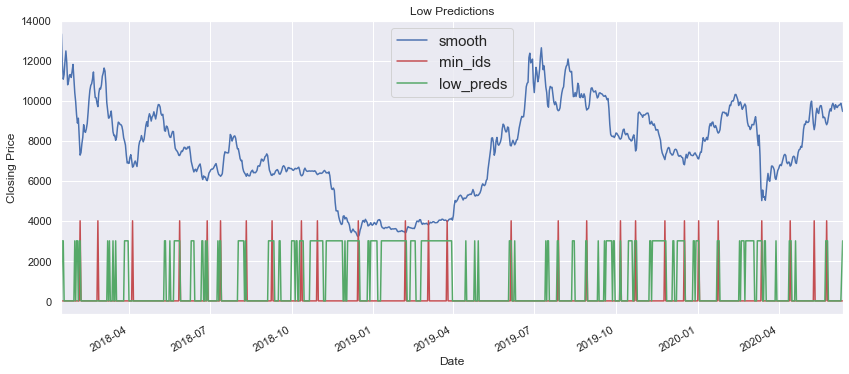

In [30]:
plt.figure(figsize=(14,6))
clean_bit.smooth.plot()
(4000*clean_bit.min_ids).plot(color='r')
(3000*clean_bit.low_preds).plot(color='g')
plt.ylabel('Closing Price')
plt.title('Low Predictions')
plt.legend(fontsize=15);

- In general, we were able to predict the lows 
- Our model also identified other price points as lows

In [30]:
# Lets pull up our dataframe to see which days are the true lows and predicted lows
clean_bit[['Close', 'smooth','min_ids', 'low_preds']].tail(25)

,Close,smooth,min_ids,low_preds
Date,,,,
2020-05-17,9670.74,9643.264157,0,0
2020-05-18,9726.58,9752.092960,0,0
2020-05-19,9729.04,9738.894336,0,0
2020-05-20,9522.98,9469.746169,0,0
2020-05-21,9081.76,9141.985291,0,0
2020-05-22,9182.58,9178.612409,0,0
2020-05-23,9209.29,9133.719153,0,0
2020-05-24,8790.37,8908.626434,0,1
2020-05-25,8906.93,8796.820054,1,1


### RSI Graph

- 70 or higher: overbought or overvalued
- 30 or less: underbought or undervalued
- This graph can show use the flow of the stock's momentum if the value is too high or too low
- RSI can help us predict the possibility of a future drop or a raise.

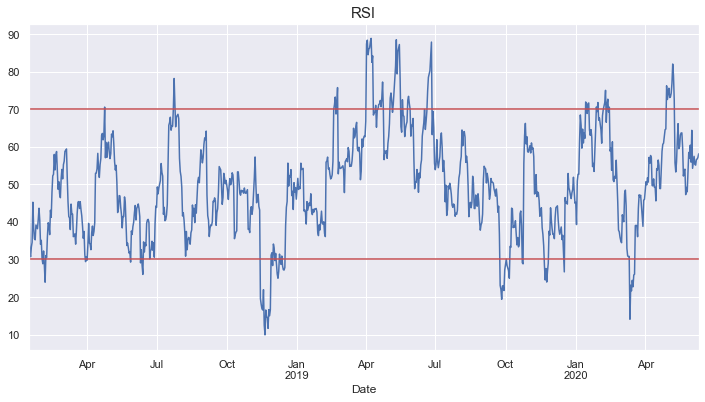

In [31]:
plt.figure(figsize=(12,6))
plt.yticks(np.arange(0,100, step=10))
clean_bit.RSI.plot()
plt.axhline(y=30, color='r')
plt.axhline(y=70, color='r')
plt.title('RSI', fontsize=15);